# <font color='orange'> Imports </font>


In [ ]:
import xml.etree.ElementTree as ET
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from datetime import datetime

from google.colab import drive
import os
import numpy as np
from tqdm.auto import tqdm


import json

class JSONEncoder(json.JSONEncoder):
    def default(self, obj):
        if hasattr(obj, 'to_json'):
            return obj.to_json(orient='records')
        return json.JSONEncoder.default(self, obj)

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.chdir('/content/drive/My Drive/FYDP_ML_work') # Ainley's directory     

# <font color='orange'> Reading and Cleaning Apple Health Kit Data </font>


In [ ]:
# create element tree object
tree_ss = ET.parse('sleep_stage.xml') 
# for every health record, extract the attributes
root_ss = tree_ss.getroot()
record_list = [x.attrib for x in root_ss.iter('Record')]

# get sleep data in time range
record_data_ss = pd.DataFrame(record_list)

# proper type to dates
for col in ['creationDate', 'startDate', 'endDate']:
    record_data_ss[col] = pd.to_datetime(record_data_ss[col])
    record_data_ss[col] = record_data_ss[col].apply(lambda t: t.replace(tzinfo=None))

# shorter observation names
record_data_ss['type'] = record_data_ss['type'].str.replace('HKCategoryTypeIdentifierSleepAnalysis', '')
# record_data.head()

def get_sleep_from_to(df, start, end):
    start = pd.to_datetime(start, utc=False)
    end = pd.to_datetime(end, utc=False)
    sleeps = df[df["creationDate"] >= start]
    sleeps = sleeps[sleeps["creationDate"] <= end]
    return sleeps

lower_time = dt.date(2023, 2, 27)
upper_time = dt.date(2023, 2, 28)
sleeps = get_sleep_from_to(record_data_ss, lower_time, upper_time)

sleeps['time'] = sleeps['startDate']

# Drop all rows that have "In Bed" because we don't need this value and it duplicates
sleeps.drop(sleeps[sleeps['value'] == 'HKCategoryValueSleepAnalysisInBed'].index, inplace = True)


# <font color='orange'> Plotting Sleep Stage Data </font>


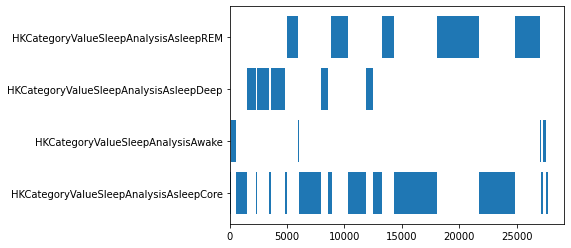

In [ ]:
# Plot the sleep stage data

df = sleeps
df['time_to_start'] = (df['startDate'] - df['startDate'].min()).dt.seconds
df['time_to_end'] = (df['endDate'] - df['startDate'].min()).dt.seconds
df['task_duration'] = df['time_to_end'] - df['time_to_start'] + 1  # to include also the end date
plt.barh(y=df['value'], width=df['task_duration'], left=df['time_to_start'])
plt.show()




In [ ]:

# create element tree object
tree_hr = ET.parse('heart_rate.xml') 
# for every health record, extract the attributes
root_hr = tree_hr.getroot()
record_list_hr = [x.attrib for x in root_hr.iter('Record')]

# get sleep data in time range

record_data_hr = pd.DataFrame(record_list_hr)

# proper type to dates
for col in ['creationDate', 'startDate', 'endDate']:
    record_data_hr[col] = pd.to_datetime(record_data_hr[col])
    record_data_hr[col] = record_data_hr[col].apply(lambda t: t.replace(tzinfo=None))

def get_hr_from_to(df, start, end):
    start = pd.to_datetime(start, utc=False)
    end = pd.to_datetime(end, utc=False)
    hr = df[df["creationDate"] >= start]
    hr = hr[hr["creationDate"] <= end]
    return hr

lower_time = dt.date(2023, 2, 27)
upper_time = dt.date(2023, 2, 28)
hr = get_sleep_from_to(record_data_hr, lower_time, upper_time)

hr['time'] = hr['startDate']

# Drop all rows that have "In Bed" because we don't need this value and it duplicates

hr_df = hr.drop(columns=["sourceName", "sourceVersion","unit","device","creationDate","startDate","endDate"])

# <font color='orange'> Reading Acceleration Data </font>


In [ ]:
accel = pd.read_csv("Accelerometer.csv")
accel['time'] = pd.to_datetime(accel['time']).dt.floor('S')
accel

,time,seconds_elapsed,z,y,x
0,2023-02-27 05:44:59,0.100029,0.028920,0.020033,0.025511
1,2023-02-27 05:44:59,0.119977,-0.019266,0.006213,0.027231
2,2023-02-27 05:44:59,0.139925,-0.055726,0.002767,0.044871
3,2023-02-27 05:44:59,0.159873,-0.023035,0.001690,0.025286
4,2023-02-27 05:44:59,0.179820,0.012053,-0.022346,-0.003188
...,...,...,...,...,...
1496795,2023-02-27 14:02:29,29850.064607,0.023885,-0.021783,-0.009395
1496796,2023-02-27 14:02:29,29850.084551,0.017590,-0.013017,-0.004975
1496797,2023-02-27 14:02:29,29850.104495,0.034933,-0.017610,-0.003695
1496798,2023-02-27 14:02:29,29850.124438,0.010293,-0.014688,-0.011675


# <font color='orange'> Activity Counts </font>


In [ ]:
# Change acceleration to activity counts
# Carman's code 

# <font color='orange'> Merging Sleep Stage and Activity Counts into one DF </font>


In [ ]:
accel_ss_df = pd.merge_asof(accel.sort_values("time"), sleeps.sort_values("time"),  on="time")
accel_ss_hr_df = pd.merge_asof(accel_ss_df.sort_values("time"), hr_df.sort_values("time"),  on="time")
cleaned_df = accel_ss_hr_df.drop(columns=["sourceName", "sourceVersion", "type_x", "type_y"])
cleaned_df

,time,seconds_elapsed,z,y,x,creationDate,startDate,endDate,value_x,value_y
0,2023-02-27 05:44:59,0.100029,0.028920,0.020033,0.025511,2023-02-27 09:24:31,2023-02-27 05:16:35,2023-02-27 06:19:05,HKCategoryValueSleepAnalysisAsleepCore,61
1,2023-02-27 05:44:59,0.219715,-0.144757,0.027359,-0.083923,2023-02-27 09:24:31,2023-02-27 05:16:35,2023-02-27 06:19:05,HKCategoryValueSleepAnalysisAsleepCore,61
2,2023-02-27 05:44:59,0.319453,0.119399,-0.022885,-0.055662,2023-02-27 09:24:31,2023-02-27 05:16:35,2023-02-27 06:19:05,HKCategoryValueSleepAnalysisAsleepCore,61
3,2023-02-27 05:44:59,0.279557,0.047239,-0.018873,-0.029813,2023-02-27 09:24:31,2023-02-27 05:16:35,2023-02-27 06:19:05,HKCategoryValueSleepAnalysisAsleepCore,61
4,2023-02-27 05:44:59,0.259611,0.048789,-0.043718,-0.010995,2023-02-27 09:24:31,2023-02-27 05:16:35,2023-02-27 06:19:05,HKCategoryValueSleepAnalysisAsleepCore,61
...,...,...,...,...,...,...,...,...,...,...
1496795,2023-02-27 14:02:29,29850.084551,0.017590,-0.013017,-0.004975,2023-02-27 09:24:31,2023-02-27 08:57:35,2023-02-27 09:00:35,HKCategoryValueSleepAnalysisAsleepCore,69
1496796,2023-02-27 14:02:29,29850.104495,0.034933,-0.017610,-0.003695,2023-02-27 09:24:31,2023-02-27 08:57:35,2023-02-27 09:00:35,HKCategoryValueSleepAnalysisAsleepCore,69
1496797,2023-02-27 14:02:29,29849.924999,0.047318,-0.023049,-0.001728,2023-02-27 09:24:31,2023-02-27 08:57:35,2023-02-27 09:00:35,HKCategoryValueSleepAnalysisAsleepCore,69
1496798,2023-02-27 14:02:29,29850.124438,0.010293,-0.014688,-0.011675,2023-02-27 09:24:31,2023-02-27 08:57:35,2023-02-27 09:00:35,HKCategoryValueSleepAnalysisAsleepCore,69


In [ ]:
cleaned_df.dropna()
cleaned_df.rename(columns={'seconds_elapsed': 'second', 'value_x': 'sleep_stage', 'value_y': 'hr'}, inplace=True)
dropped_cleanned_df = cleaned_df.drop(columns={"time", "creationDate", "startDate", "endDate"})
dropped_cleanned_df = dropped_cleanned_df.replace(['HKCategoryValueSleepAnalysisAwake', 'HKCategoryValueSleepAnalysisAsleepCore','HKCategoryValueSleepAnalysisAsleepDeep', 'HKCategoryValueSleepAnalysisAsleepREM'], [1,2,3,4])
dropped_cleanned_df = dropped_cleanned_df.apply(lambda x: pd.to_numeric(x,errors='ignore'))

In [ ]:
dropped_cleanned_df

,second,z,y,x,sleep_stage,hr
0,0.100029,0.028920,0.020033,0.025511,2,61.0
1,0.219715,-0.144757,0.027359,-0.083923,2,61.0
2,0.319453,0.119399,-0.022885,-0.055662,2,61.0
3,0.279557,0.047239,-0.018873,-0.029813,2,61.0
4,0.259611,0.048789,-0.043718,-0.010995,2,61.0
...,...,...,...,...,...,...
1496795,29850.084551,0.017590,-0.013017,-0.004975,2,69.0
1496796,29850.104495,0.034933,-0.017610,-0.003695,2,69.0
1496797,29849.924999,0.047318,-0.023049,-0.001728,2,69.0
1496798,29850.124438,0.010293,-0.014688,-0.011675,2,69.0


# Testing normalising the second time elapsed data

In [ ]:
def where_no_sensor_value_has_been_recorded_up_till_that_second_turn_this_to_a_val(df, val):

    fixed_df = df.copy()
    # iterate through these columns and fix the 'Nan' values
    for col in fixed_df.drop(columns=["second"], axis=1):

        # iterate backwards over rows and turn "Nan" boxes to the specified val and find where the "Nan" values stop
        i = len(fixed_df[col]) - 1
        print(fixed_df[col][i])
        while np.isnan(fixed_df[col][i]):
            fixed_df[col][i] = val
            i = i - 1

        # iterate forwards over rows and turn "Nan" boxes to the specified val and find where real values start
        j = 0
        while np.isnan(fixed_df[col][j]):
            fixed_df[col][j] = val
            j = j + 1

    return fixed_df

def fill_in_the_dfs_nan_values(df):

    # fill the "Nan" values with the value encountered before the "Nan" up until it hits the point where the rest of that column is only "Nan" values
    filled_df = df.fillna(method="ffill")

    # fill the "Nan" values with an interpolated value using the value before this "Nan" value and after this "Nan" value
    # filled_df = df.interpolate()

    return filled_df

def get_list_of_averages_for_each_col_of_all_rows(rows, val_to_fill_nans, cols_no_second_list):

    # if there are no values between the specified seconds
    if len(rows) == 0:
        # add empty row
        list_of_averages = list(np.repeat(float("nan"), len(cols_no_second_list)))

    # if there is at least one row with a value between these seconds
    elif len(rows) > 0:
        # average the values in these rows to get just 1 row with the values for each column
        list_of_averages = []
        for col in cols_no_second_list:

            # make sure that the sleep labels column only contains whole numbers - they must maintain their classification label
            if col == 'sleep_stage':
                # count the number of occurances of each value and take the one that occurs most as this value
                avg = float(rows.loc[:, col].mode()[0])
                    
            # first check if the values are all valid values - replace "Nan" with a value so these are invalid
            elif set(rows.loc[:, col]) != {val_to_fill_nans} and val_to_fill_nans in list(rows.loc[:, col]):
                count_nans = 0
                non_nan_vals = []

                # iterate through these row values to count how many invalid(-10) values there are
                for v in rows.loc[:, col]:
                    if v == val_to_fill_nans:
                        count_nans += 1
                      
                    else:
                        count_nans -= 1
                        non_nan_vals.append(v)

                # if there are more invalid rows than there are proper ones
                if count_nans > 0:
                    avg = sum(non_nan_vals)/len(non_nan_vals)

                # if there are more proper values than invalid ones
                elif count_nans < 0:
                    avg = val_to_fill_nans

                # if there is the exact same amout of invalid values and proper values, use the most common single value or the first of these most common values
                else:
                    print(rows)
                    avg = float(rows.loc[:, col].mode()[0])

            # if all the values are proper values, then just get the means of these values and populate the row with this
            else:
                avg = rows.loc[:, col].mean()
                
            list_of_averages.append(avg)

    return list_of_averages

def turn_seconds_to_a_set_interval(filled_sensor_df, second_column_step, val_to_fill_nans):

    # define a variable for the second column
    sec_col = filled_sensor_df.second

    # get a ist of the cols exluding the second column
    cols_no_second_list = filled_sensor_df.drop(columns=["second"], axis=1).columns

    # get the value of the maximum and minimum second in this dataframe
    min_second_in_df = int(round(min(sec_col) - 0.5))
    max_second_in_df = int(round(max(sec_col) + 0.5))

    # create a new dataframe that we will populate
    new_df = pd.DataFrame(columns=(filled_sensor_df.columns))

    # iterate through each second interval in this dataframe
    for i in tqdm(np.arange(min_second_in_df, max_second_in_df + second_column_step, second_column_step)):

        # get the rows between second "i - 1" and second "i"
        rows = filled_sensor_df.loc[(sec_col > i - (second_column_step - 0.00000001)) & (sec_col < i + 0.00000001)]
        rows = rows.reset_index(drop=True)
        
        list_of_averages = get_list_of_averages_for_each_col_of_all_rows(rows, val_to_fill_nans, cols_no_second_list)

        # create a dataframe row from this list
        new_df_row = pd.DataFrame([i] + list_of_averages, columns=[i], index=filled_sensor_df.columns).T

        # add this row to the new DataFrame
        new_df = pd.concat([new_df, new_df_row], axis=0)

    return new_df
     
def is_not_nan(v):
  return v == v

In [ ]:
val_to_fill_nans = -100
second_column_step = 1

In [ ]:
# set values where there was no sensor value taken to be a value instead of 'Nan'
half_filled_df = where_no_sensor_value_has_been_recorded_up_till_that_second_turn_this_to_a_val(dropped_cleanned_df, val_to_fill_nans)
# fill the Nan values in the dataframe
filled_sensor_df = fill_in_the_dfs_nan_values(half_filled_df)

# replace the "-10" values with "Nan" values
df_val_to_fill_nan_replaced = filled_sensor_df.replace(val_to_fill_nans, float("nan"))

# drop the rows that have an 'Nan' value for any of the sensors - this means that the sensor hadn't recorded it's first value yet
no_nan_values = df_val_to_fill_nan_replaced.dropna()

# turn the second column to a uniform interval by averaging the other columns
uniform_second_interval_df = turn_seconds_to_a_set_interval(no_nan_values, second_column_step, val_to_fill_nans)

# fill the nan values in the dataframe
df_with_one_sec_per_row = fill_in_the_dfs_nan_values(uniform_second_interval_df)

# reset the index
df_with_one_sec_per_row.reset_index(drop=True, inplace=True)

# clean out the rows where there is an invalid sleep state value
remove_invalid_sleep_state = df_with_one_sec_per_row[is_not_nan(df_with_one_sec_per_row["sleep_stage"])]
remove_invalid_sleep_state.reset_index(drop=True, inplace=True)

# create a new map of the subject_id to this new dataframe
new_cleaned_df = remove_invalid_sleep_state

0.0298813435226678
-0.0035946269584819
-0.0257781459875404
2
69.0


  0%|          | 0/29852 [00:00<?, ?it/s]

In [ ]:
new_cleaned_df

,second,z,y,x,sleep_stage,hr
0,1.0,0.010607,-0.003967,-0.007599,2.0,61.0
1,2.0,0.035518,0.008424,0.013018,2.0,61.0
2,3.0,0.016905,-0.029177,-0.053849,2.0,61.0
3,4.0,0.026296,-0.002719,-0.009513,2.0,61.0
4,5.0,-0.085647,0.015233,-0.016500,2.0,61.0
...,...,...,...,...,...,...
29846,29847.0,0.023954,-0.033111,-0.013315,2.0,69.0
29847,29848.0,0.023997,-0.029674,-0.014334,2.0,69.0
29848,29849.0,0.023219,-0.028858,-0.014980,2.0,69.0
29849,29850.0,0.023108,-0.026393,-0.016568,2.0,69.0


# <font color='orange'> Reading PVT data </font>


In [ ]:

# Read PVT data
pvt_df = pd.read_csv("PVT.csv")
pvt_df

# Start off with 100%

pvt_df.tail(1)


,Participant ID,Trial #,ISI,Abstime,RT,Type,# Valid Responses,# False Starts,# Timeouts,Mean RT,Standard Deviation RT,Minimum RT,Maximum RT
38,NaN,NaN,NaN,NaN,NaN,NaN,37.0,1.0,0.0,468.0,47.97128,393.0,649.0
